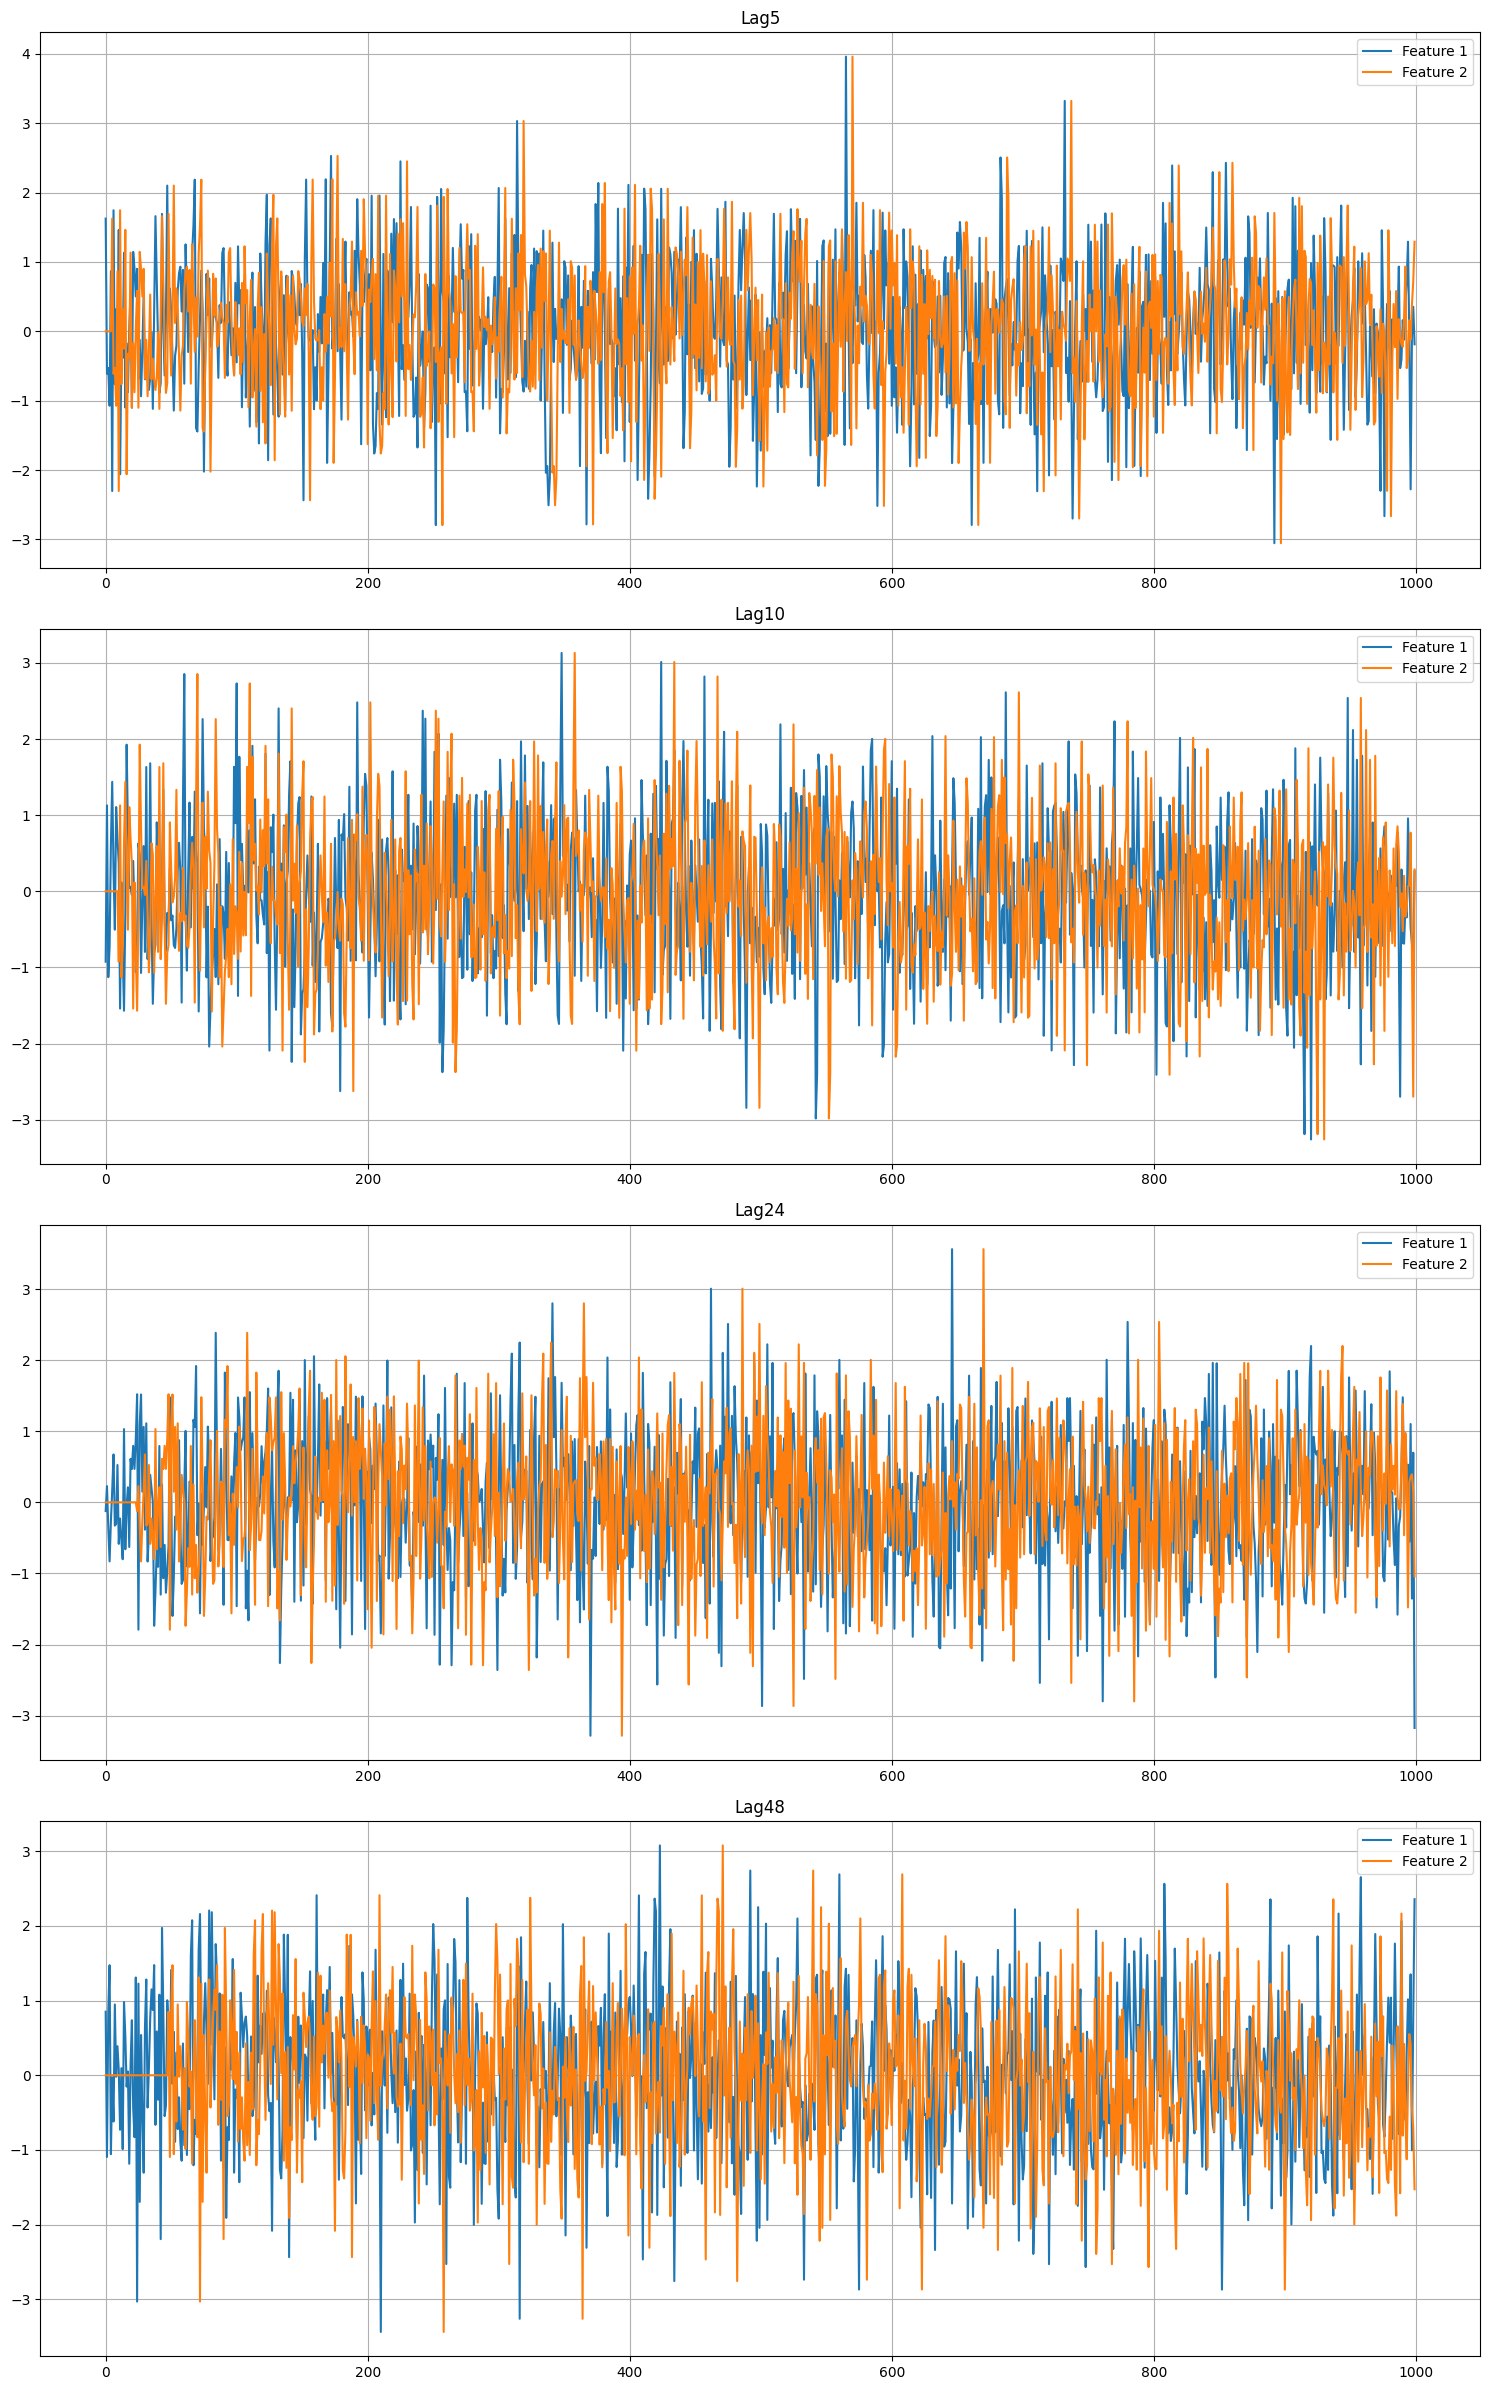

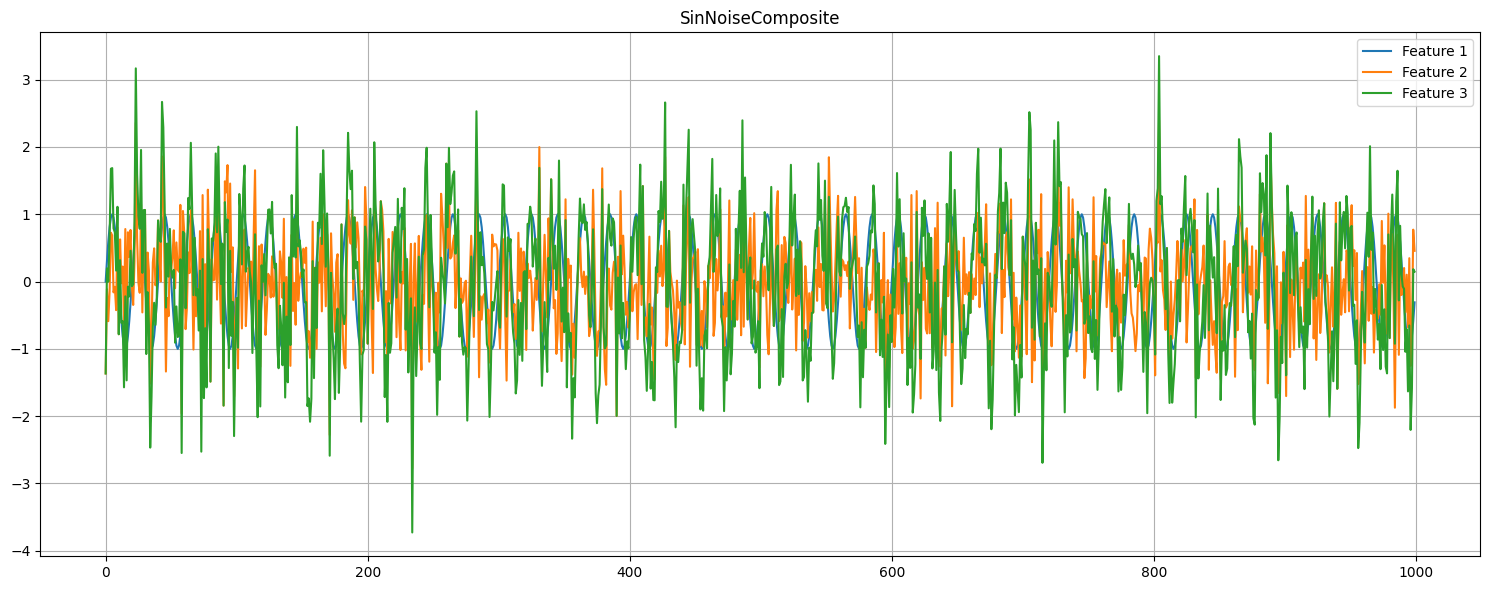

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from statsmodels.tsa.arima_process import ArmaProcess
import pandas as pd

# Basic univariate signal generation functions
def generate_linear_signal(n, slope=10, intercept=0):
    x = np.arange(n)
    return slope * x + intercept

def generate_quadratic_signal(n, a=1, b=1, c=1):
    x = np.arange(n)
    return a * x**2 + b * x + c

def generate_logistic_signal(n, L=1, k=0.1, t0=None):
    """
    Generate a logistic (sigmoid) function signal representing S-shaped growth.
    
    Parameters:
    n (int): Length of the signal
    L (float): The curve's maximum value
    k (float): The growth rate or steepness of the curve
    t0 (float): The time of the sigmoid's midpoint (defaults to n/2)
    """
    if t0 is None:
        t0 = n / 2
        
    x = np.arange(n)
    return L / (1 + np.exp(-k * (x - t0)))

def generate_sine_wave(n, amplitude=1, frequency=0.5, phase=0):
    x = np.arange(n)
    return amplitude * np.sin(2 * np.pi * frequency * x + phase)

def generate_composite_sine(n, components):
    """
    Generate a signal composed of multiple sine waves.
    
    Parameters:
    n (int): Length of the signal
    components (list): List of tuples, each containing (amplitude, frequency, phase_shift, wave_type)
                      where wave_type is 'sin' or 'cos' (defaults to 'sin' if not specified)
    
    Returns:
    numpy.ndarray: The composite signal
    """
    x = np.arange(n)
    signal = np.zeros(n)
    
    for component in components:
        if len(component) == 3:
            amplitude, frequency, phase_shift = component
            wave_type = 'sin'
        elif len(component) == 4:
            amplitude, frequency, phase_shift, wave_type = component
        else:
            raise ValueError("Each component must be a tuple of (amplitude, frequency, phase_shift) or (amplitude, frequency, phase_shift, wave_type)")
        
        if wave_type.lower() == 'sin':
            signal += amplitude * np.sin(2 * np.pi * frequency * x + phase_shift)
        elif wave_type.lower() == 'cos':
            signal += amplitude * np.cos(2 * np.pi * frequency * x + phase_shift)
        else:
            raise ValueError("wave_type must be 'sin' or 'cos'")
            
    return signal

def generate_white_noise(n, mean=0, std=1):
    return np.random.normal(mean, std, n)

# Noise addition function
def add_noise_by_snr(signal, snr_db=20):
    """Add Gaussian noise based on signal-to-noise ratio (SNR in dB)"""
    signal_power = np.var(signal)  # Signal power (variance)
    snr_linear = 10 ** (snr_db / 10)  # Convert dB to linear scale
    noise_variance = signal_power / snr_linear  # Noise variance = signal power / SNR
    noise = np.random.normal(0, np.sqrt(noise_variance), len(signal))
    return signal + noise

# Multivariate time series generation functions
def generate_lagged_features(n, lag_window=10, noise_std=1):
    """
    Generate multivariate time series: Feature B is a lagged version of Feature A
    
    Parameters:
    n (int): Signal length
    lag_window (int): Number of time steps Feature B lags behind
    noise_std (float): Standard deviation of white noise for Feature A
    
    Returns:
    tuple: (feature_a, feature_b) - Two numpy arrays representing features
    """
    # Feature A is white noise
    feature_a = generate_white_noise(n, mean=0, std=noise_std)
    
    # Feature B is a lagged version of Feature A
    feature_b = np.zeros(n)
    feature_b[lag_window:] = feature_a[:-lag_window]
    
    return feature_a, feature_b

def generate_sin_noise_composite(n, sin_frequency=0.05, sin_amplitude=1, noise_snr_db=0):
    """
    Generate multivariate time series:
    - Feature A: Sine wave
    - Feature B: Noise (with specified SNR relative to A)
    - Feature C: A + B
    
    Parameters:
    n (int): Signal length
    sin_frequency (float): Frequency of sine wave for Feature A
    sin_amplitude (float): Amplitude of sine wave for Feature A
    noise_snr_db (int): Signal-to-noise ratio (dB) of Feature B relative to A
    
    Returns:
    tuple: (feature_a, feature_b, feature_c) - Three numpy arrays representing features
    """
    # Feature A: Sine wave
    feature_a = generate_sine_wave(n, amplitude=sin_amplitude, frequency=sin_frequency)
    
    # Calculate appropriate noise level based on Feature A and SNR
    signal_power = np.var(feature_a)
    noise_power = signal_power / (10 ** (noise_snr_db / 10))
    noise_std = np.sqrt(noise_power)
    
    # Feature B: Pure noise
    feature_b = generate_white_noise(n, std=noise_std)
    
    # Feature C: A + B
    feature_c = feature_a + feature_b
    
    return feature_a, feature_b, feature_c

# Save multivariate signals to file
def save_multivariate_signal(signals, feature_names, folder, signal_name, dataset_id=None, category=None, length=None):
    """
    Save multivariate signals to CSV file
    
    Parameters:
    signals (list): List of signal arrays, each representing a feature
    feature_names (list): Feature names corresponding to signals
    folder (str): Base folder for saving
    signal_name (str): Signal name
    dataset_id (int, optional): Dataset ID
    category (str, optional): Category (e.g., raw, SNR20dB)
    length (int, optional): Signal length
    """
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    # Build filename
    filename = signal_name
    if dataset_id is not None:
        filename = f"dataset{dataset_id}_{filename}"
    if category is not None:
        filename = f"{filename}_{category}"
    if length is not None:
        filename = f"{filename}_length{length}"
    
    # Create timestamp column
    timestamps = np.arange(len(signals[0]))
    
    # Create DataFrame containing all features
    data = {'date': timestamps}
    for signal, feature_name in zip(signals, feature_names):
        data[feature_name] = signal
    
    df = pd.DataFrame(data)
    
    # Save as CSV
    df.to_csv(os.path.join(folder, f"{filename}.csv"), index=False)

# Visualize multivariate signals
def plot_multivariate_signals(signal_data_dict, n_samples_to_plot=1000):
    """
    Plot multivariate signals, showing all features for each dataset
    
    Parameters:
    signal_data_dict (dict): Dictionary of signal data, where keys are signal names
                           and values are tuples/lists of feature arrays
    n_samples_to_plot (int): Number of samples to show in the plot (to avoid overcrowding)
    """
    n_signals = len(signal_data_dict)
    
    plt.figure(figsize=(15, 6 * n_signals))
    
    for i, (name, signals) in enumerate(signal_data_dict.items()):
        plt.subplot(n_signals, 1, i + 1)
        
        # For each feature in the signals
        if isinstance(signals, tuple) or isinstance(signals, list):
            for j, signal in enumerate(signals):
                # Only plot a subset of points to avoid overcrowding
                plt.plot(signal[:n_samples_to_plot], label=f"Feature {j+1}")
        else:
            # If it's a single signal
            plt.plot(signals[:n_samples_to_plot], label="Feature 1")
            
        plt.title(name)
        plt.grid(True)
        plt.legend()
        
    plt.tight_layout()
    plt.show()

# Generate and save multivariate datasets
def generate_and_save_multivariate_datasets(seed, dataset_folder, dataset_id):
    """
    Generate and save multivariate time series datasets
    """
    n = 5000  # Signal length
    np.random.seed(seed)  # Set random seed
    
    # 1. Generate datasets with different lag features
    lags = [5, 10, 24, 48]
    lag_signals = {}
    
    for lag in lags:
        feature_a, feature_b = generate_lagged_features(n, lag_window=lag)
        signal_name = f"Lag{lag}"
        lag_signals[signal_name] = (feature_a, feature_b)
        
        # Save multivariate signal
        save_multivariate_signal(
            [feature_a, feature_b], 
            ["FeatureA_WhiteNoise", f"FeatureB_Lag{lag}"], 
            dataset_folder, signal_name, dataset_id, "raw", n
        )
    
    # Plot lag signals
    plot_multivariate_signals(lag_signals)
    
    # 2. Generate Sine-Noise-Composite datasets
    sin_freq = 0.05
    sin_amplitude = 1
    
    # Generate 0dB SNR case
    feature_a, feature_b, feature_c = generate_sin_noise_composite(n, sin_freq, sin_amplitude, 0)
    signal_name = "SinNoiseComposite"
    composite_signals = {signal_name: (feature_a, feature_b, feature_c)}
    
    # Save multivariate signal
    save_multivariate_signal(
        [feature_a, feature_b, feature_c], 
        ["FeatureA_Sin", "FeatureB_Noise_0dB", "FeatureC_Sum"], 
        dataset_folder, signal_name, dataset_id, "raw", n
    )
    
    # Plot composite signals
    plot_multivariate_signals(composite_signals)

# Main function for generating multiple datasets
def generate_multiple_datasets(num_datasets=5):
    output_multivariate_folder = "Dataset_generated_multivariate"
    
    if not os.path.exists(output_multivariate_folder):
        os.makedirs(output_multivariate_folder)
    
    for i in range(num_datasets):
        seed = i
        # Generate multivariate datasets
        generate_and_save_multivariate_datasets(seed, output_multivariate_folder, i+1)
        
if __name__ == "__main__":
    generate_multiple_datasets(num_datasets=1)  # Generate 1 example dataset